In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Style configuration
sns.set_theme(style="whitegrid")

csv_file = 'transactional-sample.csv'

# Attempt to load the file
try:
    ts = pd.read_csv(csv_file)
    print(f"File '{csv_file}' loaded successfully!")
    
    # Convert date column to datetime objects (Crucial for time analysis)
    ts['transaction_date'] = pd.to_datetime(ts['transaction_date'])

    print("\n--- First 5 transactions ---")
    display(ts.head())

    print("\n--- Last 5 transactions ---")
    display(ts.tail())
    
    print("\n--- Data Info ---")
    ts.info() #Quick summary 
    
except FileNotFoundError:
    print(f"ERROR: The file '{csv_file}' was not found in the folder.")

File 'transactional-sample.csv' loaded successfully!

--- First 5 transactions ---


,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk
0,21320398,29744,97051,434505******9116,2019-12-01 23:16:32.812632,374.56,285475.0,False
1,21320399,92895,2708,444456******4210,2019-12-01 22:45:37.873639,734.87,497105.0,True
2,21320400,47759,14777,425850******7024,2019-12-01 22:22:43.021495,760.36,NaN,False
3,21320401,68657,69758,464296******3991,2019-12-01 21:59:19.797129,2556.13,NaN,True
4,21320402,54075,64367,650487******6116,2019-12-01 21:30:53.347051,55.36,860232.0,False



--- Last 5 transactions ---


,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk
3194,21323592,50493,49581,650486******4139,2019-11-01 13:05:34.054967,744.15,NaN,False
3195,21323593,9603,59275,528052******3611,2019-11-01 11:47:02.404963,1403.67,NaN,False
3196,21323594,57997,84486,522688******9874,2019-11-01 10:23:50.555604,1.55,NaN,False
3197,21323595,35930,7,544315******7773,2019-11-01 01:29:45.799767,359.68,NaN,False
3198,21323596,17348,8,650487******9884,2019-11-01 01:27:15.811098,2416.70,NaN,False



--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3199 entries, 0 to 3198
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   transaction_id      3199 non-null   int64         
 1   merchant_id         3199 non-null   int64         
 2   user_id             3199 non-null   int64         
 3   card_number         3199 non-null   object        
 4   transaction_date    3199 non-null   datetime64[ns]
 5   transaction_amount  3199 non-null   float64       
 6   device_id           2369 non-null   float64       
 7   has_cbk             3199 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 178.2+ KB


In [55]:
import pandas as pd
import os

try:
    ts = pd.read_csv('transactional-sample.csv')
    print("Main file 'transactional-sample.csv' loaded successfully!")
except FileNotFoundError:
    print("Error: Main file not found.")
    ts = pd.DataFrame()

# --- 2. CALCULATION & EXPORT FUNCTION ---
if not ts.empty:
    print("GENERATING FEATURE STORE (CSV FILES)...")

    def generate_and_save_score(df, entity_col, filename):
        """
        Calculates Laplace Score for an entity and saves to CSV.
        """
        # 1. Aggregation
        stats = df.groupby(entity_col)['has_cbk'].agg(['count', 'sum']).reset_index()
        stats.columns = [entity_col, 'Total_Trans', 'Total_Frauds']
        
        # 2. Laplace Formula: (Frauds + 1) / (Total + 2)
        stats['Risk_Score'] = (stats['Total_Frauds'] + 1) / (stats['Total_Trans'] + 2) #laplace was used due to its low complexity and great results when handling small samples
        
        # 3. Keep only relevant columns for the "Database"
        # We keep Total_Trans just for reference
        output_df = stats[[entity_col, 'Risk_Score', 'Total_Trans']].sort_values(by='Risk_Score', ascending=False) #sorting optional
        
        # 4. Save to CSV
        output_df.to_csv(filename, index=False)
        print(f"Saved {len(output_df)} records to '{filename}'")
        
        return output_df

    # --- A. EXPORT USER SCORES ---
    user_score_df = generate_and_save_score(ts, 'user_id', 'user_score.csv')
    qnt = 10 #variable to store how many of an element i want to show
    # Show preview
    print("Preview of user_score.csv:")
    display(user_score_df.head(qnt))

    # --- B. EXPORT MERCHANT SCORES ---
    merchant_score_df = generate_and_save_score(ts, 'merchant_id', 'merchant_score.csv')
    
    # Show preview
    print("Preview of merchant_score.csv:")
    display(merchant_score_df.head(qnt))

    # --- C. VERIFICATION ---
    # Check if files actually exist in the OS
    print("\nVERIFYING FILES ON DISK:")
    if os.path.exists('user_score.csv'):
        print(f" -> user_score.csv exists ({os.path.getsize('user_score.csv')})")
    if os.path.exists('merchant_score.csv'):
        print(f" -> merchant_score.csv exists ({os.path.getsize('merchant_score.csv')})")

else:
    print("DataFrame 'ts' is empty.")

Main file 'transactional-sample.csv' loaded successfully!
GENERATING FEATURE STORE (CSV FILES)...
Saved 2704 records to 'user_score.csv'
Preview of user_score.csv:


,user_id,Risk_Score,Total_Trans
2020,75710,0.916667,10
211,7725,0.888889,7
2582,96025,0.875000,14
484,17929,0.875000,6
584,21768,0.875000,6
2085,78262,0.866667,13
2683,99396,0.857143,5
1904,71424,0.857143,5
2316,86411,0.857143,5
741,28218,0.857143,5


Saved 1756 records to 'merchant_score.csv'
Preview of merchant_score.csv:


,merchant_id,Risk_Score,Total_Trans
20,1308,0.941176,15
830,44927,0.923077,11
1309,73271,0.916667,10
704,38337,0.875000,6
1445,81795,0.875000,6
879,48126,0.875000,6
1341,75917,0.875000,6
710,38568,0.857143,5
168,8942,0.857143,5
302,15326,0.857143,5



VERIFYING FILES ON DISK:
 -> user_score.csv exists (72686)
 -> merchant_score.csv exists (43570)


In [57]:
import pandas as pd
import os

# --- 1. SAFETY LOADING ---
try:
    ts = pd.read_csv('transactional-sample.csv')
    print("Main file 'transactional-sample.csv' loaded successfully!")
except FileNotFoundError:
    print("Error: Main file not found.")
    ts = pd.DataFrame()

# --- 2. CALCULATION & EXPORT ---
if not ts.empty and 'card_number' in ts.columns: # Due to the need of extracting Bin, i decided not to integrate the bin_score with the function of users and merchant score
    # 1. Extract BIN (First 6 digits)
    # This represents the Issuing Bank (e.g., Nubank, Bradesco, Chase)
    ts['card_bin'] = ts['card_number'].astype(str).str[:6]

    def generate_bin_score(df, filename):
        # 2. Aggregation
        stats = df.groupby('card_bin')['has_cbk'].agg(['count', 'sum']).reset_index()
        stats.columns = ['card_bin', 'Total_Trans', 'Total_Frauds']
        
        # 3. Laplace Formula: (Frauds + 1) / (Total + 2)
        stats['Risk_Score'] = (stats['Total_Frauds'] + 1) / (stats['Total_Trans'] + 2)
        
        # 4. Sort by Risk (optional)
        output_df = stats[['card_bin', 'Risk_Score', 'Total_Trans']].sort_values(by='Risk_Score', ascending=False)
        
        # 5. Save to CSV
        output_df.to_csv(filename, index=False)
        print(f"Saved {len(output_df)} records to '{filename}'")
        
        return output_df

    # --- EXPORT BIN SCORES ---
    bin_score_df = generate_bin_score(ts, 'bin_score.csv')
    
    # Show preview
    print("Preview of bin_score.csv:")
    qnt = 10
    display(bin_score_df.head(qnt))

    # --- VERIFICATION ---
    if os.path.exists('bin_score.csv'):
        print(f"VERIFYING FILE ON DISK:")
        print(f" -> bin_score.csv exists ({os.path.getsize('bin_score.csv')} bytes)")

else:
    print("DataFrame 'ts' is empty or 'card_number' column is missing.")

Main file 'transactional-sample.csv' loaded successfully!
Saved 410 records to 'bin_score.csv'
Preview of bin_score.csv:


,card_bin,Risk_Score,Total_Trans
376,554482,0.916667,10
93,441030,0.833333,4
307,537110,0.750000,2
267,530034,0.675676,35
322,542976,0.666667,1
139,474512,0.666667,1
77,430535,0.666667,1
89,439027,0.666667,1
395,650727,0.666667,4
379,554927,0.666667,1


VERIFYING FILE ON DISK:
 -> bin_score.csv exists (10043 bytes)


[OK] All files loaded and types aligned!
[INFO] ASSEMBLING THE DATASET...
[INFO] Splitting Data into Train/Test...
[INFO] Training Random Forest on 2239 transactions...
[INFO] Evaluating with Custom Threshold: 65.0%

RESULTADOS FINAIS DO MODELO (METRICAS)
Total Transacoes de Teste: 960
------------------------------------------------------------
 TRUE POSITIVES (Fraude Pega):         112  (Fraude Bloqueada)
 TRUE NEGATIVES (Legitimo Aprovado):   838  (Bons Usuarios Aprovados)
 FALSE POSITIVES (Alarme Falso):       5  (Bons Usuarios Bloqueados)
 FALSE NEGATIVES (Fraude Perdida):     5  (Fraude Passou)
------------------------------------------------------------
 TAXAS CHAVE:
   * Precision (Confiabilidade):    95.73%  (Meta: Alta)
   * Recall (Taxa de Deteccao):     95.73%  (Meta: Alta)
   * False Positive Rate (Ruido):   0.59%  (Meta: Baixa)
   * False Negative Rate (Risco):   4.27%  (Meta: Baixa)


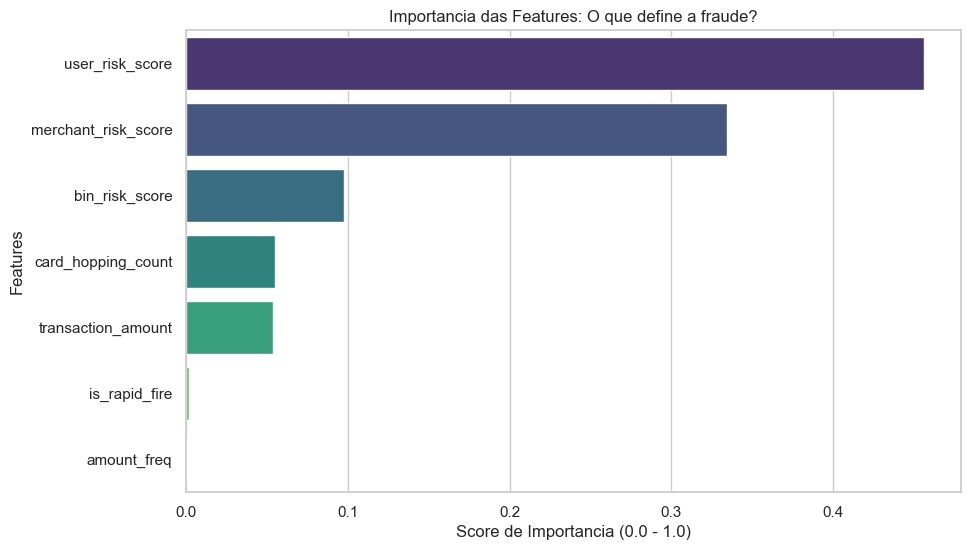


[INFO] INICIANDO MOTOR DE PREVISAO PARA CASOS INDIVIDUAIS...

[TESTE] VERIFICANDO CASOS ESPECIFICOS:

Input 1 (Perfil de Risco): {'transaction_id': 123456789, 'recommendation': 'DENY', 'risk_score': 1.0, 'threshold': 0.65}
Input 2 (Perfil Seguro):   {'transaction_id': 999222, 'recommendation': 'APPROVE', 'risk_score': 0.3, 'threshold': 0.65}


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix

# Style configuration
sns.set_theme(style="whitegrid")

# ==========================================
# 1. DATA LOADING AND SETUP
# ==========================================
try:
    # A. Main transaction data
    ts = pd.read_csv('transactional-sample.csv')
    ts['transaction_date'] = pd.to_datetime(ts['transaction_date'])
    
    # FIX 1: Input Cleaning (Drop rows with missing essential data)
    ts = ts.dropna(subset=['transaction_amount', 'user_id', 'merchant_id', 'card_number', 'transaction_date'])
    
    # B. Feature Store (Risk Scores)
    user_scores = pd.read_csv('user_score.csv')
    merchant_scores = pd.read_csv('merchant_score.csv')
    bin_scores = pd.read_csv('bin_score.csv')
    
    # --- CRITICAL FIX FOR MERGE TYPES ---
    # Ensure all IDs are strings to avoid Object vs Int64 errors
    ts['user_id'] = ts['user_id'].astype(str)
    ts['merchant_id'] = ts['merchant_id'].astype(str)
    user_scores['user_id'] = user_scores['user_id'].astype(str)
    merchant_scores['merchant_id'] = merchant_scores['merchant_id'].astype(str)
    bin_scores['card_bin'] = bin_scores['card_bin'].astype(str)
    
    print("[OK] All files loaded and types aligned!")
    
except FileNotFoundError as e:
    print(f"[ERROR] File not found: {e}")
    ts = pd.DataFrame()

if not ts.empty:
    print("[INFO] ASSEMBLING THE DATASET...")

    # --- PREPARE JOINS AND DICTIONARIES (For Future Prediction) ---
    # Create dictionaries for fast lookup in the Prediction Function
    user_score_map = user_scores.set_index('user_id')['Risk_Score'].to_dict()
    merchant_score_map = merchant_scores.set_index('merchant_id')['Risk_Score'].to_dict()
    bin_score_map = bin_scores.set_index('card_bin')['Risk_Score'].to_dict()

    # Prepare Dataframes for Merge
    user_scores = user_scores[['user_id', 'Risk_Score']].rename(columns={'Risk_Score': 'user_risk_score'})
    merchant_scores = merchant_scores[['merchant_id', 'Risk_Score']].rename(columns={'Risk_Score': 'merchant_risk_score'})
    bin_scores = bin_scores[['card_bin', 'Risk_Score']].rename(columns={'Risk_Score': 'bin_risk_score'})

    ts['card_bin'] = ts['card_number'].astype(str).str[:6]

    # --- 3. MERGE SCORES ---
    ts = ts.merge(user_scores, on='user_id', how='left')
    ts = ts.merge(merchant_scores, on='merchant_id', how='left')
    ts = ts.merge(bin_scores, on='card_bin', how='left')

    # Fill Missing Scores (New entities get 0.5 neutral risk)
    ts['user_risk_score'] = ts['user_risk_score'].fillna(0.5)
    ts['merchant_risk_score'] = ts['merchant_risk_score'].fillna(0.5)
    ts['bin_risk_score'] = ts['bin_risk_score'].fillna(0.5)

    # --- 4. DYNAMIC FEATURE ENGINEERING (BATCH) ---
    ts = ts.sort_values(by=['user_id', 'transaction_date'])
    
    # Velocity: Time since last transaction
    ts['time_since_last'] = ts.groupby('user_id')['transaction_date'].diff().dt.total_seconds().fillna(999999)
    ts['is_rapid_fire'] = (ts['time_since_last'] < 300).astype(int)
    
    # Card Hopping: Unique cards per user
    ts['card_hopping_count'] = ts.groupby('user_id')['card_number'].transform('nunique')
    
    # Amount Frequency: How common is this transaction amount?
    ts['amount_freq'] = ts.groupby('transaction_amount')['transaction_amount'].transform('count') / len(ts)

    # ==========================================
    # 2. MODEL TRAINING
    # ==========================================
    print("[INFO] Splitting Data into Train/Test...")
    
    # List of features used for training
    feature_names = [
        'transaction_amount', 
        'user_risk_score', 
        'merchant_risk_score', 
        'bin_risk_score',
        'is_rapid_fire', 
        'card_hopping_count',
        'amount_freq'
    ]
    
    X = ts[feature_names].fillna(0)
    y = ts['has_cbk'].astype(int)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    print(f"[INFO] Training Random Forest on {len(X_train)} transactions...")
    rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42, max_depth=10)
    rf_model.fit(X_train, y_train)

    # ==========================================
    # 3. EVALUATION
    # ==========================================
    CUSTOM_THRESHOLD = 0.65
    
    y_probs = rf_model.predict_proba(X_test)[:, 1]
    y_pred_custom = (y_probs >= CUSTOM_THRESHOLD).astype(int)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_custom).ravel()

    precision = precision_score(y_test, y_pred_custom)
    recall = recall_score(y_test, y_pred_custom)

    fp_rate = fp / (tn + fp) if (tn + fp) > 0 else 0
    fn_rate = fn / (tp + fn) if (tp + fn) > 0 else 0

    print("\n" + "="*60)
    print("Final results of the model")
    print("="*60)
    print(f"Total transactions test: {len(y_test)}")
    print("-" * 60)
    print(f" TRUE POSITIVES   {tp}")
    print(f" TRUE NEGATIVES   {tn}")
    print(f" FALSE POSITIVES  {fp}")
    print(f" FALSE NEGATIVES  {fn}")
    print("-" * 60)
    print(f" Key rates:")
    print(f"   * Precision (reliability):    {precision:.2%}  (Meta: Alta)")
    print(f"   * Recall (Detection rate):     {recall:.2%}  (Meta: Alta)")
    print(f"   * False Positive Rate (Noise/Mistake):   {fp_rate:.2%}  (Meta: Baixa)")
    print(f"   * False Negative Rate (Noise/Mistake):   {fn_rate:.2%}  (Meta: Baixa)")
    print("="*60)
    
    # Visualizacao de Importancia
    importances = pd.Series(rf_model.feature_importances_, index=feature_names).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=importances.values, 
        y=importances.index, 
        hue=importances.index, 
        legend=False, 
        palette='viridis'
    )
    plt.title("Importance of features")
    plt.xlabel("Score (0.0 - 1.0)")
    plt.ylabel("Features")
    plt.show()

    # ==========================================
    # 4. Predicting function (API SIMULATOR)
    # ==========================================

    def predict_new_transaction(payload):
        """
        Calcula features em tempo real e preve fraude para um unico payload JSON.
        """
        # 1. Parse Input
        u_id = str(payload['user_id'])
        m_id = str(payload['merchant_id'])
        amount = payload['transaction_amount']
        card = payload['card_number']
        date = pd.to_datetime(payload['transaction_date'])

        # 2. Feature Lookup
        u_score = user_score_map.get(u_id, 0.5)
        m_score = merchant_score_map.get(m_id, 0.5)
        b_score = bin_score_map.get(str(card)[:6], 0.5)

        # 3. Calculos em Tempo Real
        user_history = ts[ts['user_id'] == u_id].sort_values('transaction_date')
        
        if not user_history.empty:
            last_time = user_history['transaction_date'].max()
            if date > last_time:
                seconds = (date - last_time).total_seconds()
            else:
                seconds = 999999
        else:
            seconds = 999999
            
        is_rapid = 1 if seconds < 300 else 0

        cards_used = set(user_history['card_number'].unique())
        cards_used.add(card)
        hopping_count = len(cards_used)

        amt_freq = len(ts[ts['transaction_amount'] == amount]) / len(ts) if len(ts) > 0 else 0

        input_data = pd.DataFrame([[
            amount, u_score, m_score, b_score, is_rapid, hopping_count, amt_freq
        ]], columns=feature_names)

        # 5. 
        prob = rf_model.predict_proba(input_data)[0][1]
        decision = "DENY" if prob >= CUSTOM_THRESHOLD else "APPROVE"

        return {
            "transaction_id": payload['transaction_id'],
            "recommendation": decision,
            "risk_score": round(prob, 4),
            "threshold": CUSTOM_THRESHOLD
        }

    # ==========================================
    # 5. Specific cases
    # ==========================================
    print("\n[Test results:")

    risky_case = {
        "transaction_id": 123456789,
        "merchant_id": 73271,
        "user_id": 75710, 
        "card_number": "554482******9116",
        "transaction_date": "2019-12-01T23:59:59.000000",
        "transaction_amount": 1454,
        "device_id": 285475
    }
    safe_case = {
        "transaction_id": 999222,
        "merchant_id": 29744,
        "user_id": 99999999,
        "card_number": "555555******5555",
        "transaction_date": "2020-01-01T12:00:00.000000",
        "transaction_amount": 45,
        "device_id": 111111
    }

    print(f"\nInput 1 (Perfil de Risco): {predict_new_transaction(risky_case)}")
    print(f"Input 2 (Perfil Seguro):   {predict_new_transaction(safe_case)}")